In [100]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special

rr = np.arange(12, 18, 1)
atom = [13,20,32,50,79]
rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772  # cm

cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


voigt_path_11_8 = r'/home/jin/T_Cloudy/CIV_Voigt_data/CIV_Voigt_11_8.txt'
voigt_path_30 = r'/home/jin/T_Cloudy/CIV_Voigt_data/CIV_Voigt_30.txt'
voigt_path_50 = r'/home/jin/T_Cloudy/CIV_Voigt_data/CIV_Voigt_50.txt'

NN = int(1e4)


C_IV_N = np.linspace(1e12, 1e17, NN)

def N_esc_scat(line,voigt_path,v_th):


    name = ['lambda','sigma']
    voigt_file = pd.read_csv(voigt_path,sep='\s+',names=name,)
    lam_0, scat_0 = voigt_file['lambda'].to_numpy() , voigt_file['sigma'].to_numpy()

    del_V =  ((lam_0-C_IV_K) / C_IV_K) * cc /1e5
    x =   del_V / (v_th/1e5)
    K_H_center = 250  / (v_th/1e5)
    dx = x[1] - x[0]
    x_K = x[np.where(x <= K_H_center)[0]]
    x_H = x[np.where(x >= K_H_center)[0]]
    scat_K = scat_0[np.where(x <= K_H_center)[0]]
    scat_H = scat_0[np.where(x >= K_H_center)[0]]
    x_0 = np.zeros(NN)

    xx_K = 0
    xx_H = 500/ (v_th/1e5)

    if line =='K' or line =='k' :
        x = x_K
        scat = scat_K
        xx_c = xx_K
        ii = np.where( (x > -dx/2) & (x < dx/2) )[0]
        cross_sec_cen, N_CIV_cen =  (scat[ii]) ,1/scat[ii]

    elif line == 'H' or line =='h' :
        x = x_H 
        scat = scat_H
        xx_c = xx_H
        jj = np.where( (x > xx_H -dx/2) & (x < xx_H +dx/2) )[0]
        cross_sec_cen, N_CIV_cen =  (scat[jj]) ,1/scat[jj]



    tau_profile = np.outer(C_IV_N, scat)
    
    # print(line,'scattering cross-section = ', cross_sec_cen )
    print(line,'Center  Columne density = ', N_CIV_cen  )


    for ii, jj in enumerate(C_IV_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = x[x_p].max() if x_p.size > 0 else 0


    V_del_peak = 2*abs( (x_0 - xx_c)*(v_th/1e5))

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    # V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    
    return x ,tau_profile , V_del_peak , N_esc

From RT_scat Voigt_function

In [101]:
# v_th = v_th_CIV
# y_1 = N_esc_scat('k',voigt_path_11_8,v_th)[2]

# v_th= 30e5
# y_2 = N_esc_scat('k',voigt_path_30,v_th)[2]

# v_th= 50e5
# y_3 = N_esc_scat('k',voigt_path_50,v_th)[2]


# fig = plt.figure(1,figsize=(7,5))
# v_th = v_th_CIV
# plt.plot(C_IV_N , y_1,'r-')

# v_th= 30e5
# plt.plot(C_IV_N ,y_2 ,'b-')

# v_th= 50e5
# plt.plot(C_IV_N , y_3,'g-')


# plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
# plt.xscale('log')
# plt.xlim(2*10**12,10**17)
# # plt.ylim(halo_V_K_peak_1.min()-2,halo_V_K_peak_1.max()+2)
# plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
# plt.minorticks_on()
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.grid()

In [102]:
def calculate_order_and_value(value):
    """ 주어진 값에 대해 변환된 값과 해당 order 반환 """

    if value == 0 :
        return "000" , 0
    elif value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    elif value < 1000:
        return int(value), 2
    else :
        return int(value / 10), 3


#combine K and H lines
def data_sp_com(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}spec_com.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)


    lam = data[0].to_numpy()
    spec_tot = data[1].to_numpy()
    spec_sc = data[2].to_numpy()
   # spec_pol_tot = data[3]
   # spec_pol_scat = data[4]
    return lam , spec_tot , spec_sc



#separate K and H line
def data_sp(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}spec.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)


    x = data[0].to_numpy()
    if Line == 'h' or Line =='H':
        lam = -  C_IV_H_A / ( (vran/cc_k)*x -1)
        spec_tot = data[2].to_numpy()
        spec_scat = data[4].to_numpy()

    elif Line == 'k' or Line =='K':
        lam = - C_IV_K_A / ( (vran/cc_k)*x -1)
        spec_tot = data[1].to_numpy()
        spec_scat = data[3].to_numpy()       

    
    return lam , spec_tot , spec_scat


def data_scat(Line , atom_num , atom_index, vout, vemit, vran):
    out, out_order = calculate_order_and_value(vout)
    emit, emit_order = calculate_order_and_value(vemit)
    ran , ran_order = calculate_order_and_value(vran)

    path = r'/home/jin/data_CIV/N_atom{}0E+{}_Vexp{}E+0{}_Vemit{}E+0{}_tauD000E+00_Vran{}E+0{}_f_esc.dat'.format(atom_num, atom_index , out, out_order, emit, emit_order, ran, ran_order)
    try:
        data = pd.read_csv(path, sep='\s+', header=None)
    except:
        print('파일을 찾을 수 없습니다.',path)

    if Line == 'k' or Line =='K':
        N_sct = data.iloc[0,4]

    elif Line == 'h' or Line =='H':
        N_sct = data.iloc[0,5]

    return N_sct
    


def K_H_from_Combine_data(Line , atom_num , atom_index, vout, vemit, vran):
    lam , spec_tot , spec_halo =  data_sp_com(Line , atom_num , atom_index, vout, vemit, vran)
    lam_c =  (C_IV_K_A + C_IV_H_A) / 2
    if Line == 'k' or Line =='K':
        ioc = np.where(lam<=lam_c)[0]
        lam_x = lam[ioc]
        spec_tot_x = spec_tot[ioc]
        spec_halo_x  = spec_halo[ioc]

    elif Line == 'h' or Line =='H':
        ioc = np.where(lam>=lam_c)[0]
        lam_x = lam[ioc]
        spec_tot_x = spec_tot[ioc]
        spec_halo_x  = spec_halo[ioc]
    else :
        lam_x  = lam 
        spec_tot_x = spec_tot
        spec_halo_x = spec_halo

    return lam_x , spec_tot_x , spec_halo_x

lam, spec_tot , spec_halo = K_H_from_Combine_data('all',50,14,200,400,100)
# plt.plot(lam,spec_tot)
# plt.axvline(x=1549,ymin=0,ymax=2)

from scipy.signal import find_peaks

# 빛의 속도 (km/s)

def del_v_peaks(Line, atom_num, atom_index, vout, vemit, vran):
    lam, spec_tot, spec_halo = data_sp_com(Line, atom_num, atom_index, vout, vemit, vran)

    # 모든 피크 찾기
    peaks, properties = find_peaks(spec_halo)

    if len(peaks) < 2:
        # 피크가 2개 미만이면 del_v = 0
        del_v = 0
        peak_lambda = []
        peak_values = []
    else:
        # 모든 피크 중 강도 높은 상위 2개 선택
        peak_intensities = spec_halo[peaks]
        top_2_indices = np.argsort(peak_intensities)[-2:]  # 가장 강한 2개의 피크 선택
        top_2_indices = peaks[top_2_indices]  # 원래 인덱스로 변환

        # 피크 파장 및 강도
        peak_lambda = lam[top_2_indices]
        peak_values = spec_halo[top_2_indices]

        # 기준 파장 설정 (C_IV_K_A, C_IV_H_A는 미리 정의되어 있어야 함)
        if Line in ['k', 'K']:
            lambda_0 = C_IV_K_A
        elif Line in ['h', 'H']:
            lambda_0 = C_IV_H_A
        else:
            raise ValueError("Invalid Line input. Must be 'k' or 'h'.")

        # **추가: 피크 강도 차이가 10,000 이상이면 double peak이 아님**
        if abs(peak_values[0] - peak_values[1]) > 20000  or abs(peak_lambda[0] - peak_lambda[1]) < 0.05 :
            del_v = 0
        else:
            # 속도 변환 (v = c * (lambda - lambda_0) / lambda_0)
            peak_velocities = cc_k * (peak_lambda - lambda_0) / lambda_0
            del_v = abs(peak_velocities[1] - peak_velocities[0])  # 속도 차이 계산

    return del_v, peak_lambda



Analytic_Solution

In [103]:
NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0) ,"{:.5e}".format(sig_c)  )

def tau(sig_c, x):
    return sig_c * x

def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak

3.39090e+13 2.94907e-14


/tmp/ipykernel_34541/2507001845.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=25,title=r'$\sigma_{R} ~ [\rm km\,s^{-1}]$',loc='upper left',title_fontsize=25)


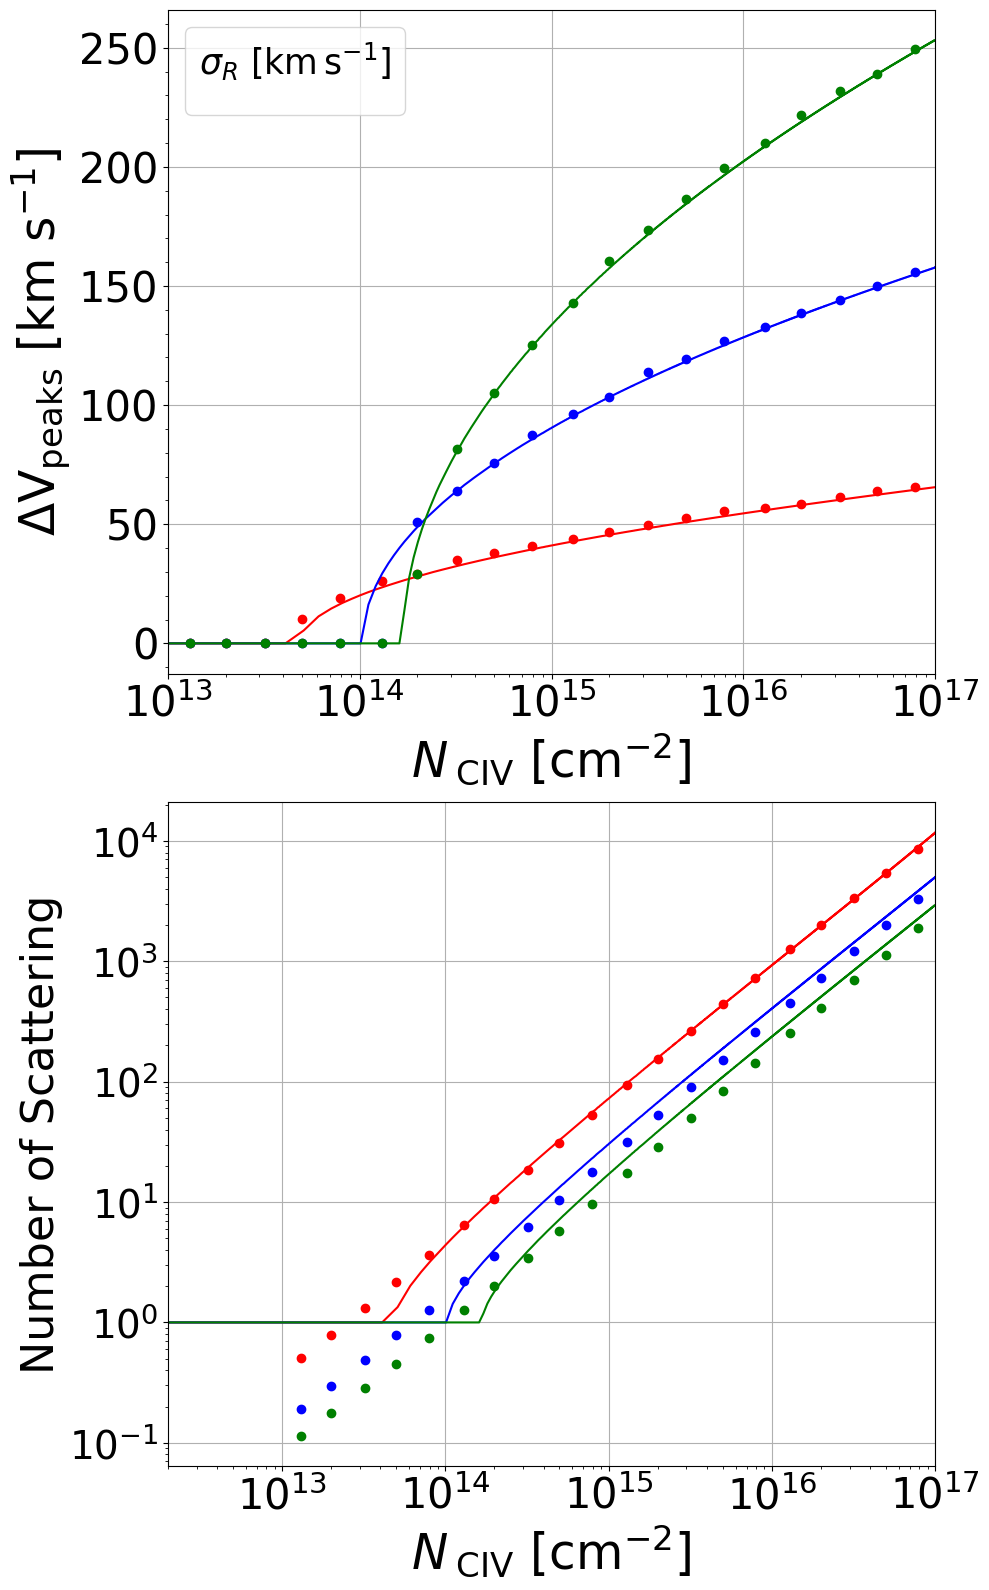

In [104]:
rr = np.arange(13, 17, 1)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()



rand_nn = [11.8 , 30 , 50]
color = ['r','b','g']

fig = plt.figure(1,figsize=(10,16))

plt.subplot(211)


for kk , rand in enumerate(rand_nn):

    vv = []
    for ii, index in enumerate(rr):
        for jj , atom in enumerate(atom_N):
            a , lam = del_v_peaks('k',atom,index,0,1,rand)
            vv.append(a)

    column_density,N_o_Scat,Del_V = N_esc_scat(rand*1e5)
    plt.plot(column_density,Del_V,'-',color = color[kk])
    plt.plot(total_N_c, vv,'o',color = color[kk])
    plt.xscale('log')

plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =35)
plt.xscale('log')
plt.xlim(1*10**13,10**17)
# plt.ylim(halo_V_K_peak_1.min()-2,halo_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =35)
plt.minorticks_on()
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.legend(fontsize=25,title=r'$\sigma_{R} ~ [\rm km\,s^{-1}]$',loc='upper left',title_fontsize=25)
plt.tight_layout()


plt.subplot(212)
for kk , rand in enumerate(rand_nn):

    vv = []
    for ii, index in enumerate(rr):
        for jj , atom in enumerate(atom_N):
            a = data_scat('k',atom,index,0,1,rand)
            vv.append(a)

    column_density,N_o_Scat,Del_V = N_esc_scat(rand*1e5)
    plt.plot(column_density,N_o_Scat,'-',color = color[kk])
    plt.plot(total_N_c, vv,'o',color = color[kk])
    plt.xscale('log')

plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =35)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=30)
plt.yticks(fontsize=28)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =32)
plt.minorticks_on()
plt.grid()
# plt.legend(fontsize=20,loc='upper left')
plt.tight_layout()

[1548.1997 1548.1771] [9944. 9944.]


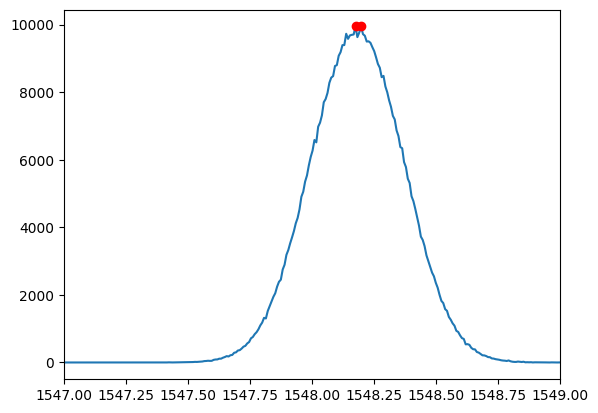

In [105]:
lam, spec_tot , spec_halo = K_H_from_Combine_data('k',13,13,0,1,50)
plt.plot(lam,spec_halo)
plt.xlim(1547,1549)

peaks, _ = find_peaks(spec_halo, height=0.5) 

# print(lam[peaks])
tt = np.argsort(spec_halo[peaks])[-2:]
aa = peaks[tt]
peak_lam = lam[aa]
peak_val = spec_halo[aa]
print(peak_lam, peak_val)
plt.plot(peak_lam, peak_val,'ro')